In [1]:
from maelzel.partialtracking.spectrum import Spectrum
import sndfileio
from maelzel.snd.audiosample import Sample
from maelzel.partialtracking import plotting
from maelzel import stats
from pitchtools import *
import matplotlib.pyplot as plt
import numpy as np
from maelzel.partialtracking import pack

%matplotlib inline


In [2]:
# samples, info = sndfileio.sndget("../snd/CountDownFrom10-M.flac")
samples, info = sndfileio.sndget("../snd/finneganswake-fragm01.flac")


In [3]:
samples1 = samples[:, 0].copy() if info.channels == 2 else samples
sp = Spectrum.analyze(samples1, sr=info.samplerate, resolution=60, windowsize=80, freqdrift=40)
sp = Spectrum([p for p in sp if len(p) >= 2])
sp

Spectrum(numpartials=20158, start=0.037, end=15.976, density=7085.9)

We use .synthesize instead of .play because we want the sound to be embedded in the notebook

Sample(dur=68.21172335600907, sr=44100, ch=1)
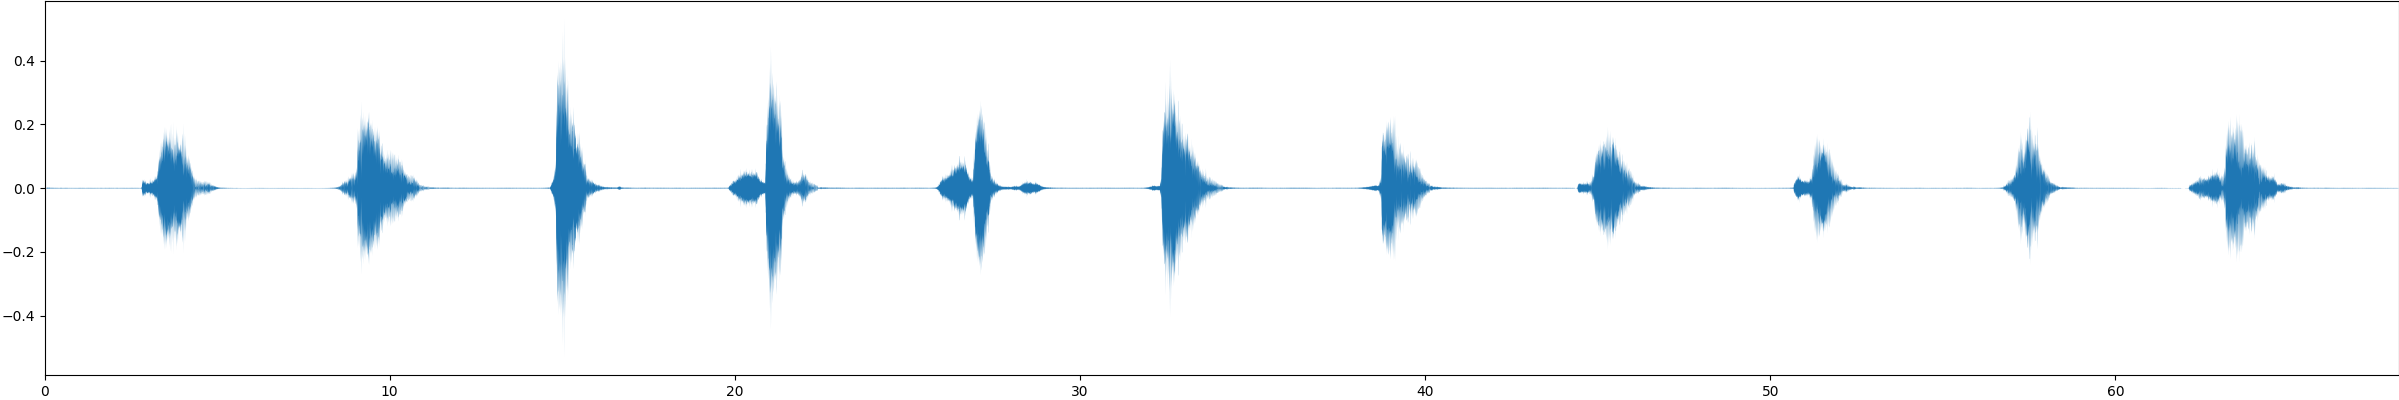

In [4]:
sp.timeScale(6).synthesize()

Spectrum(numpartials=17133, start=0.043, end=15.971, density=6639.5) Spectrum(numpartials=3025, start=1.209, end=15.976, density=487.0)


Sample(dur=15.970861678004535, sr=44100, ch=1)
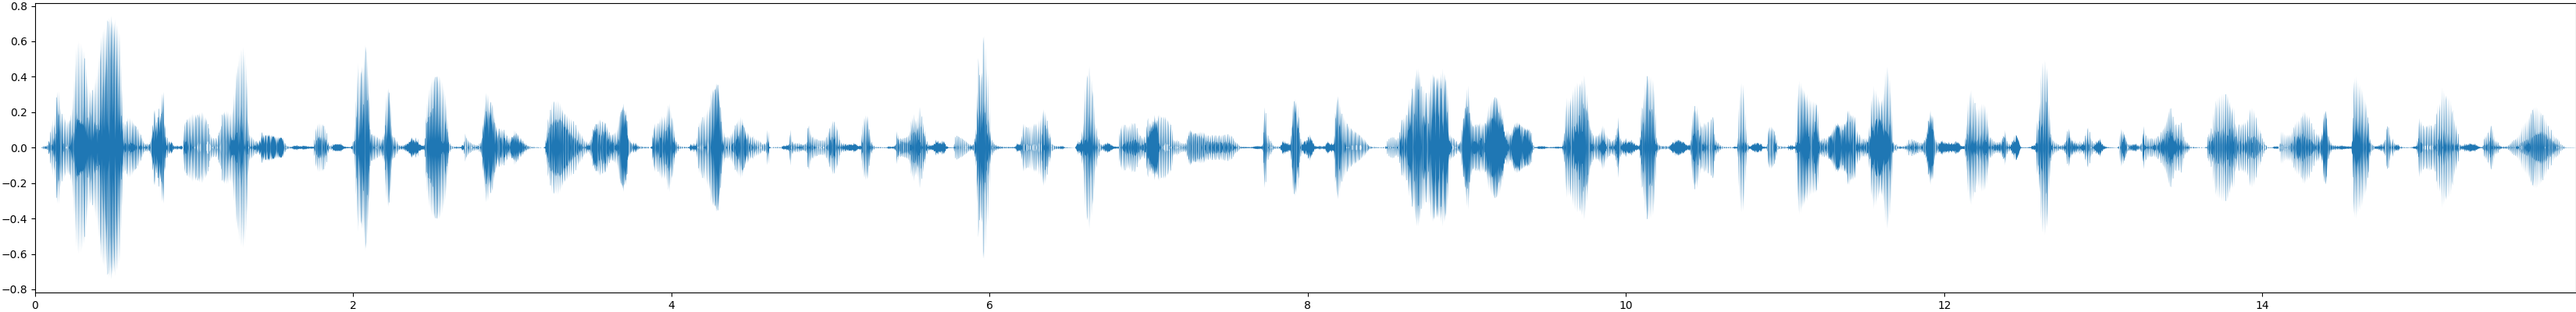

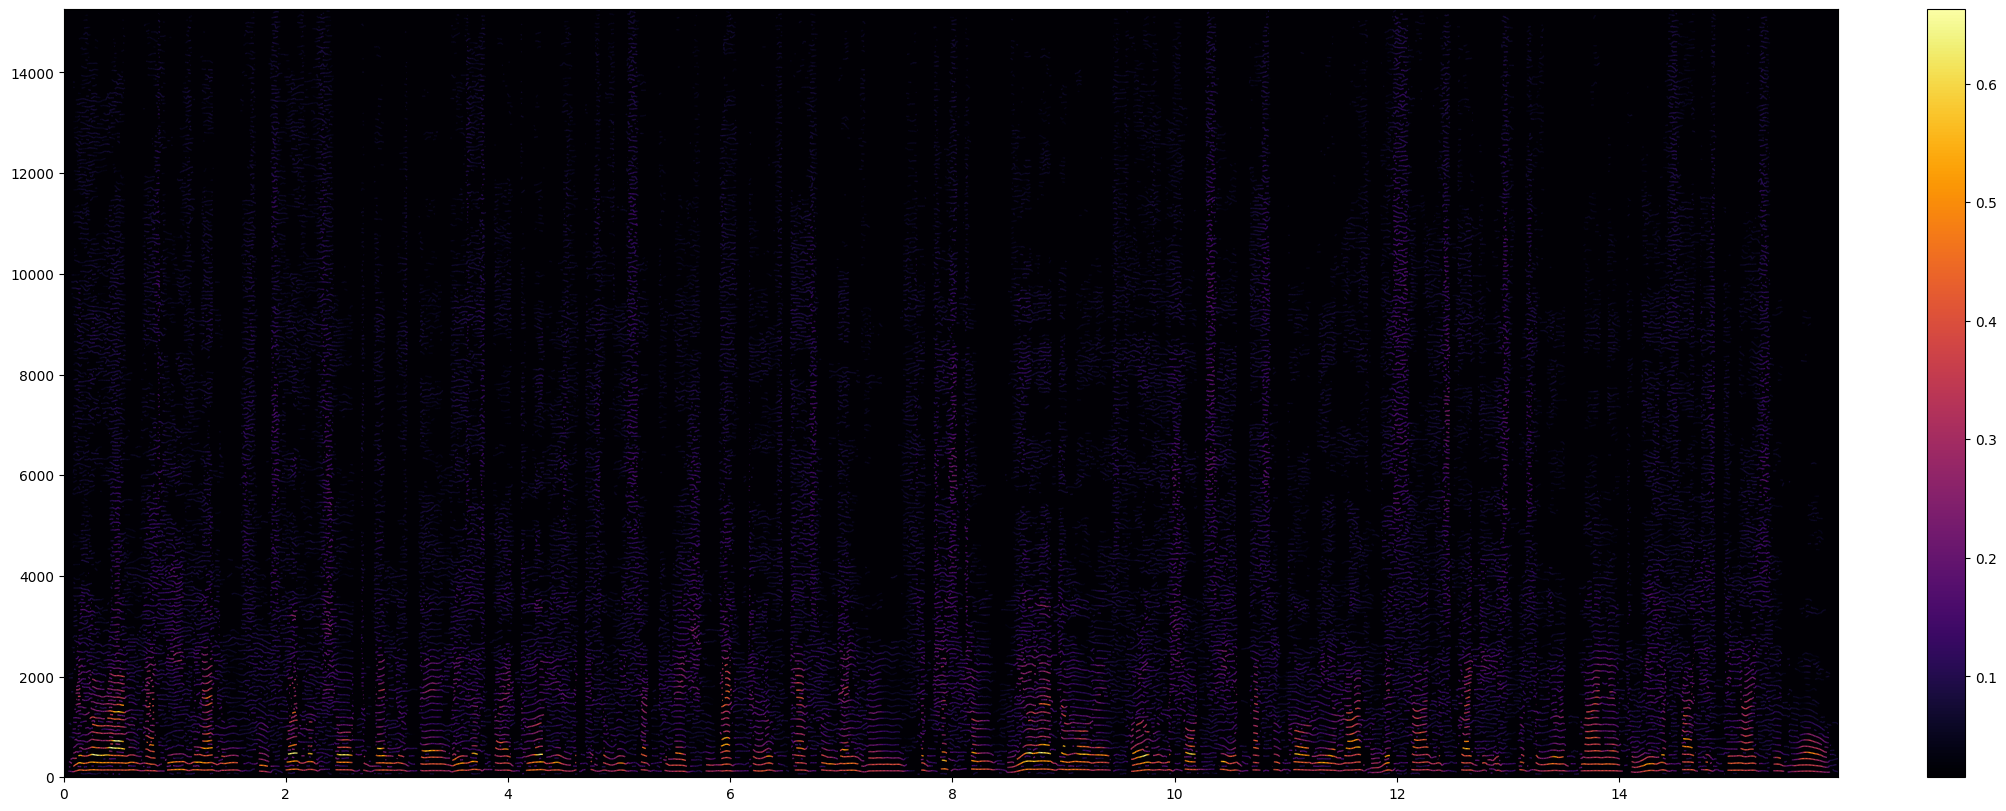

In [4]:
spA, spB = sp.filter(minpercentile=0.15, numbands=10, banddistribution=0.6)
spA.plot(exp=0.3)
print(spA, spB)
spA.synthesize()


<Axes: >

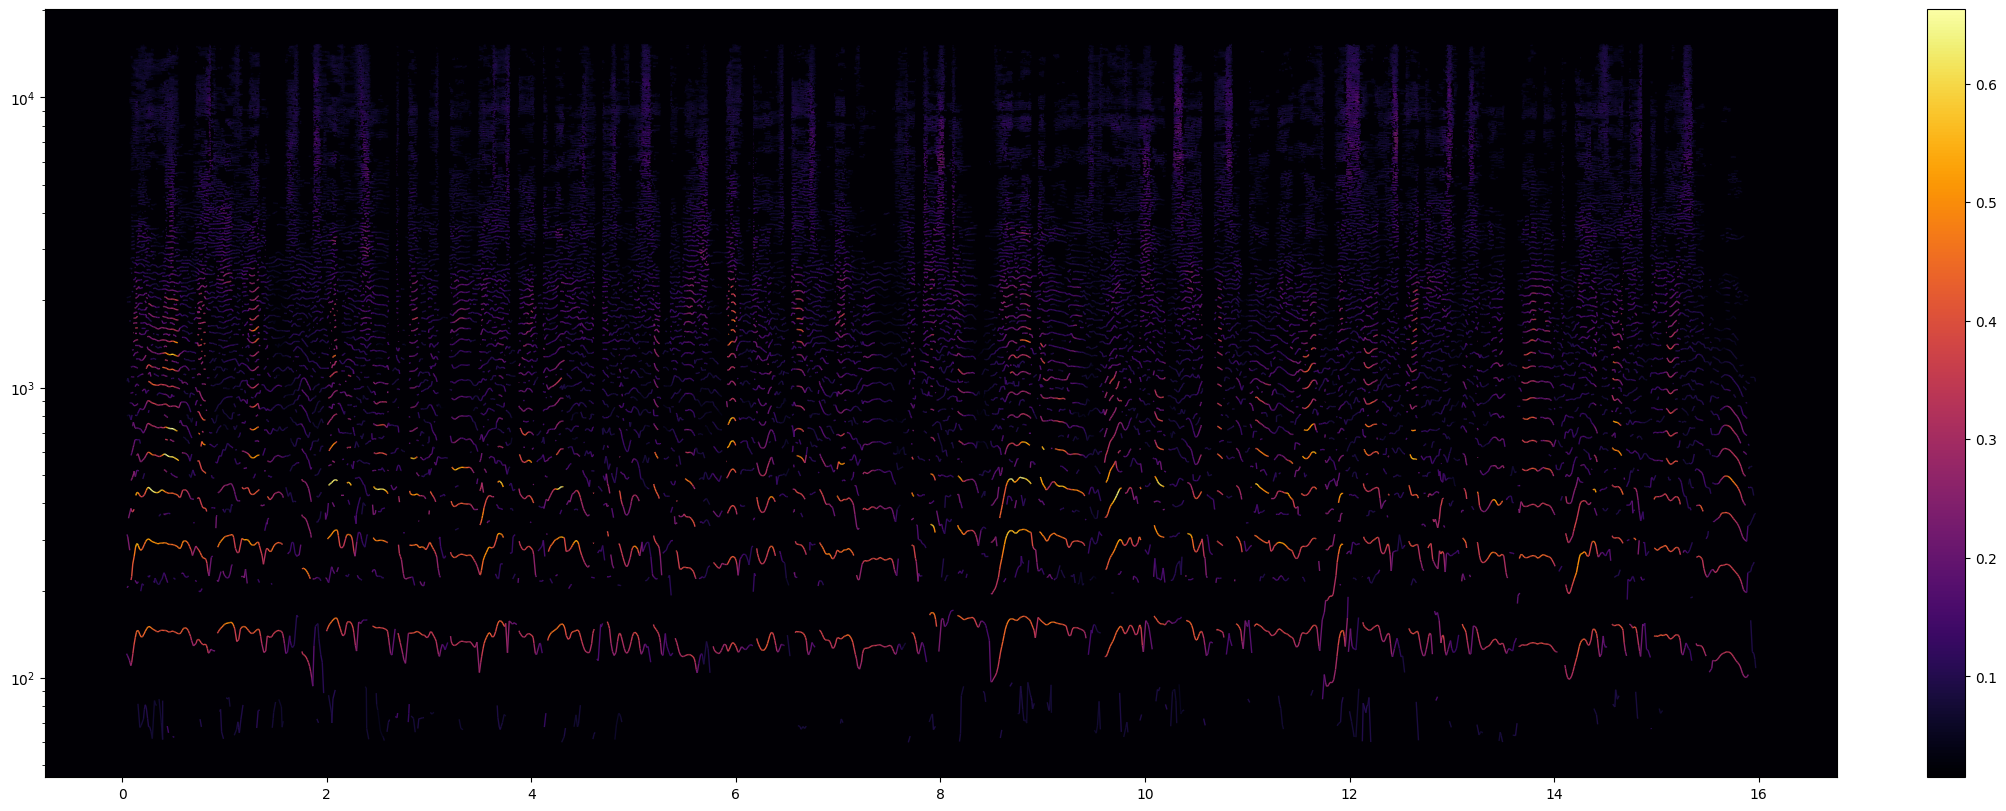

In [5]:
spA.plot(exp=0.3, scale='log')

In [4]:
timescale = 8
maxtransient = 0.2
voiced, residual = sp.filter(minpercentile=0.15, numbands=10, banddistribution=0.6)

voiced2 = voiced.timeScale(timescale)
# Apply a different stretch to transients, keeping the alignment with the voiced partials
residual2 = Spectrum([p for p in residual if p.duration < maxtransient and p.meanbw() > 0]).timeScaleOffsets(timescale, itemfactor=2)
spmix = Spectrum(voiced2.partials + residual2.partials)
spmix

Spectrum(numpartials=6934, start=0.045, end=90.937, density=516.5)

Sample(dur=90.93698412698413, sr=44100, ch=1)
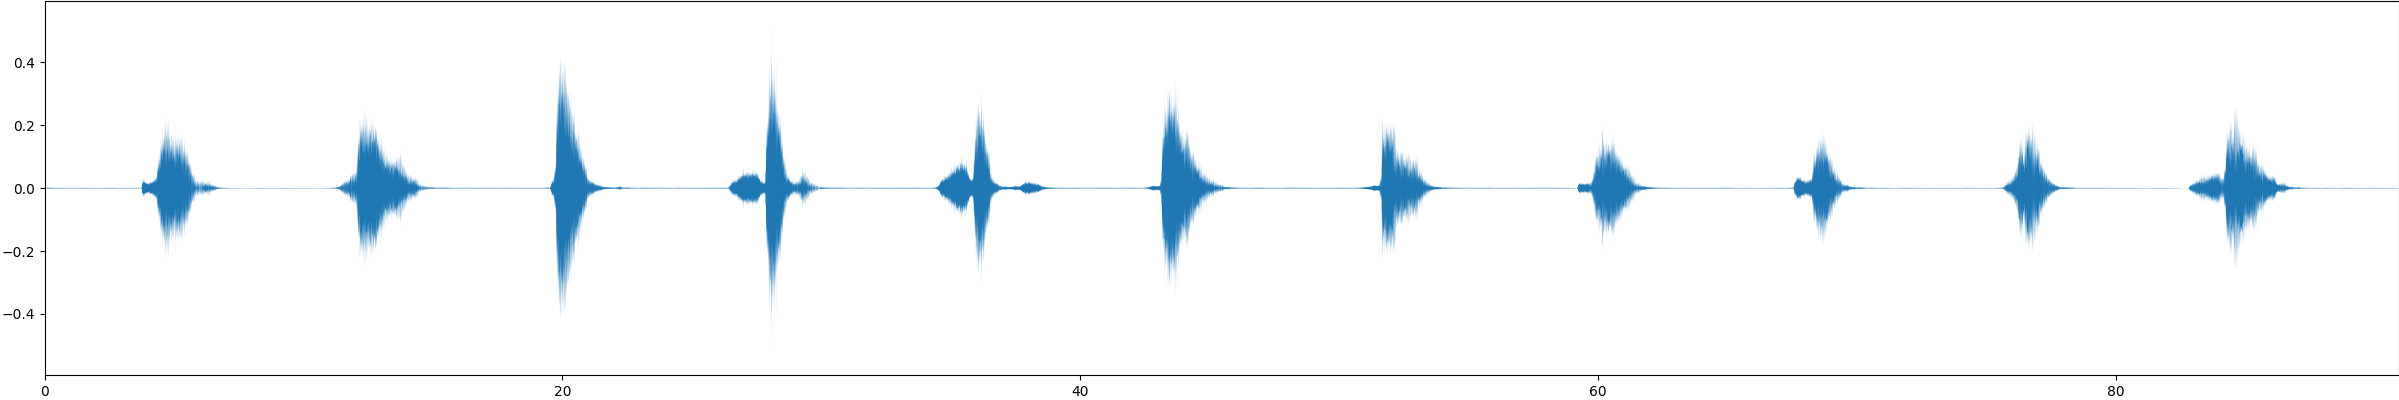

In [5]:
spmix.synthesize()

In [4]:
sp2 = Spectrum([p for p in sp.partials if len(p) > 2 and p.duration > 0.02 and p.meanfreq() < 12000])
print(f"Len sp2: {len(sp2)}, higher than 4000 hz: {len([p for p in sp2 if p.meanfreq() > 4000])}")
sp2

Len sp2: 11307, higher than 4000 hz: 6840


Spectrum(numpartials=11307, start=0.043, end=15.976, density=5370.7)

distr: 1.0725221803675227, #tracks: 10, #partials: 811, partials with freq > 3000: 15, audibility: 1.4205
Noise partials: 249


Sample(dur=15.970861678004535, sr=44100, ch=1)
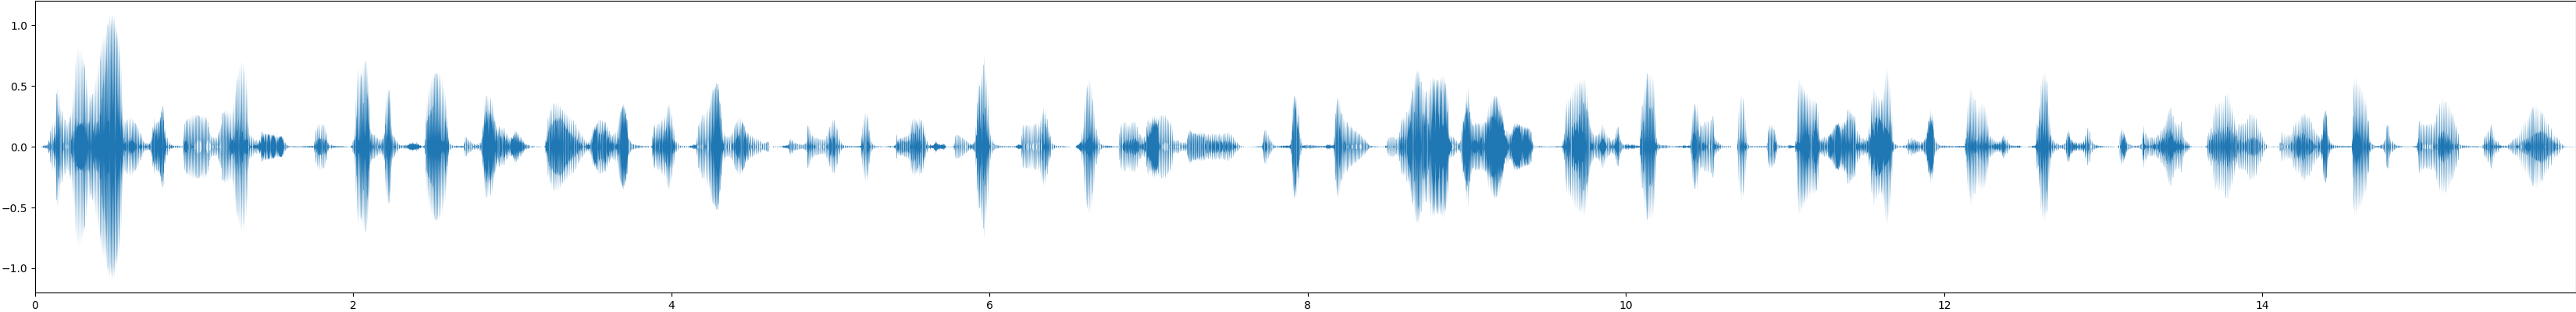

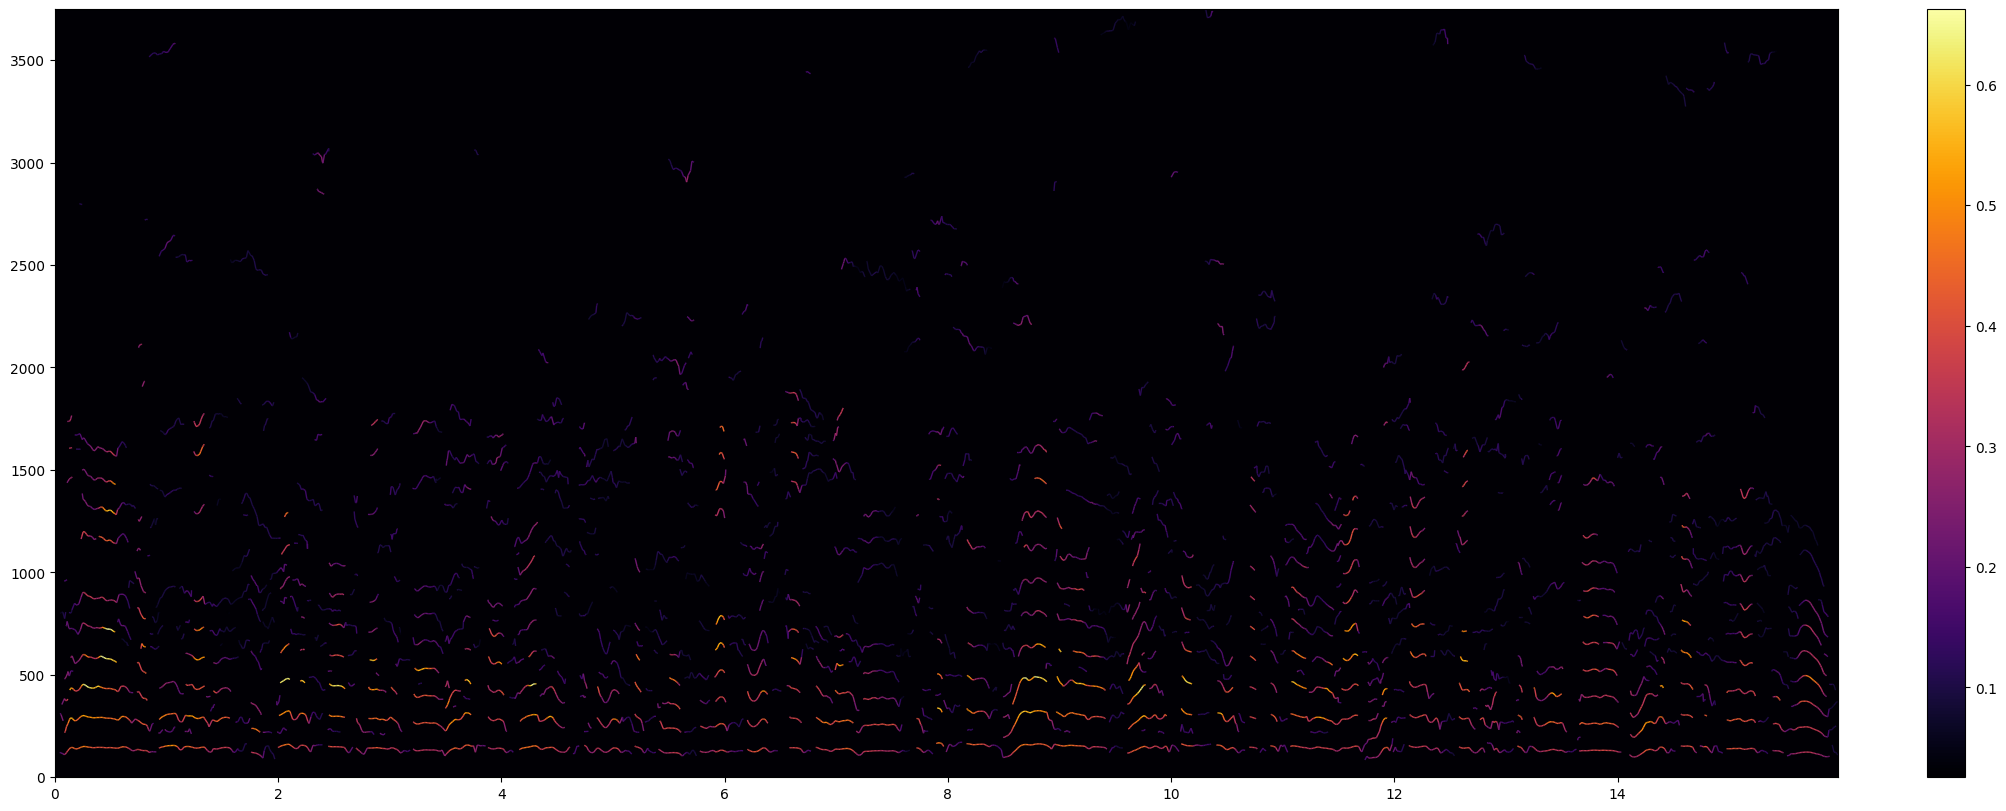

In [16]:
out = sp2.splitInTracks(maxtracks=10, distribution=None, noisetracks=3, noisefreq=2000, noisebw=0.1, relerror=0.2, _method='insert')
voicedspectrum = out.voicedSpectrum()
noisesp = out.noiseSpectrum()

print(f"distr: {out.distribution}, #tracks: {len(out.tracks)}, #partials: {len(voicedspectrum)}, partials with freq > 3000: {sum(1 for p in voicedspectrum if p.meanfreq() > 3000)}, audibility: {sum(p.audibility() for p in voicedspectrum):.5g}")
print(f"Noise partials: {len(noisesp)}") 
voicedspectrum.plot(exp=0.3)
voicedspectrum.synthesize(gain=1.5)


259 101


Sample(dur=15.898140589569161, sr=44100, ch=1)
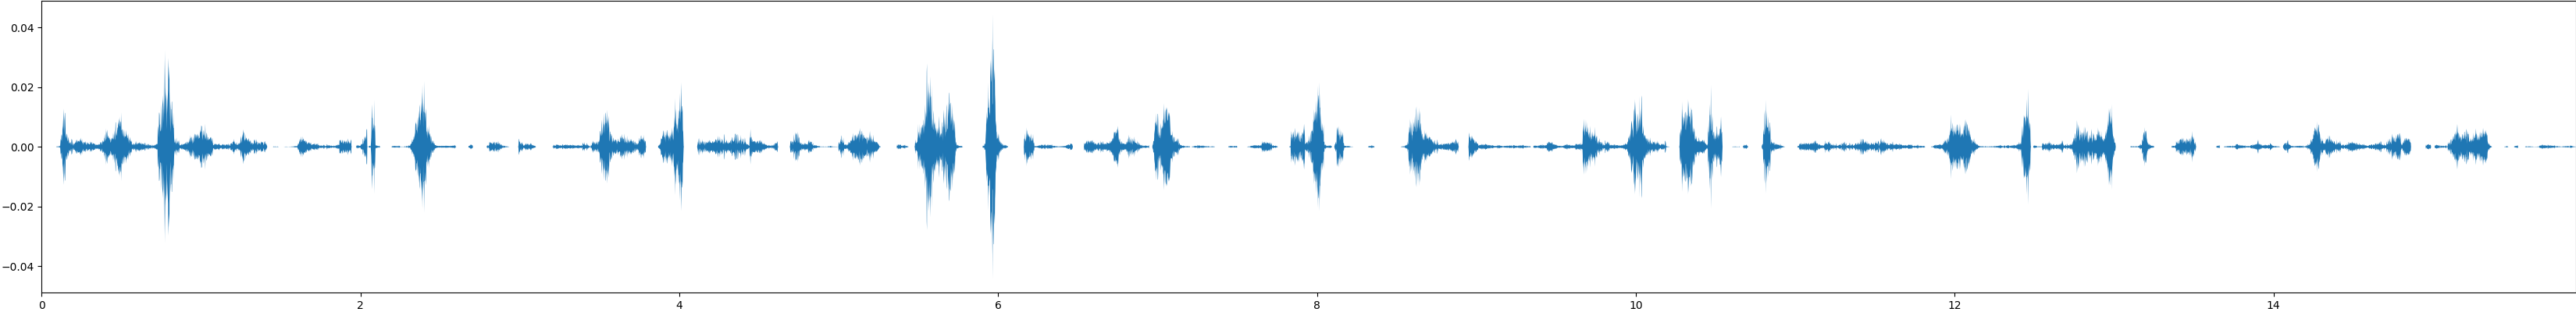

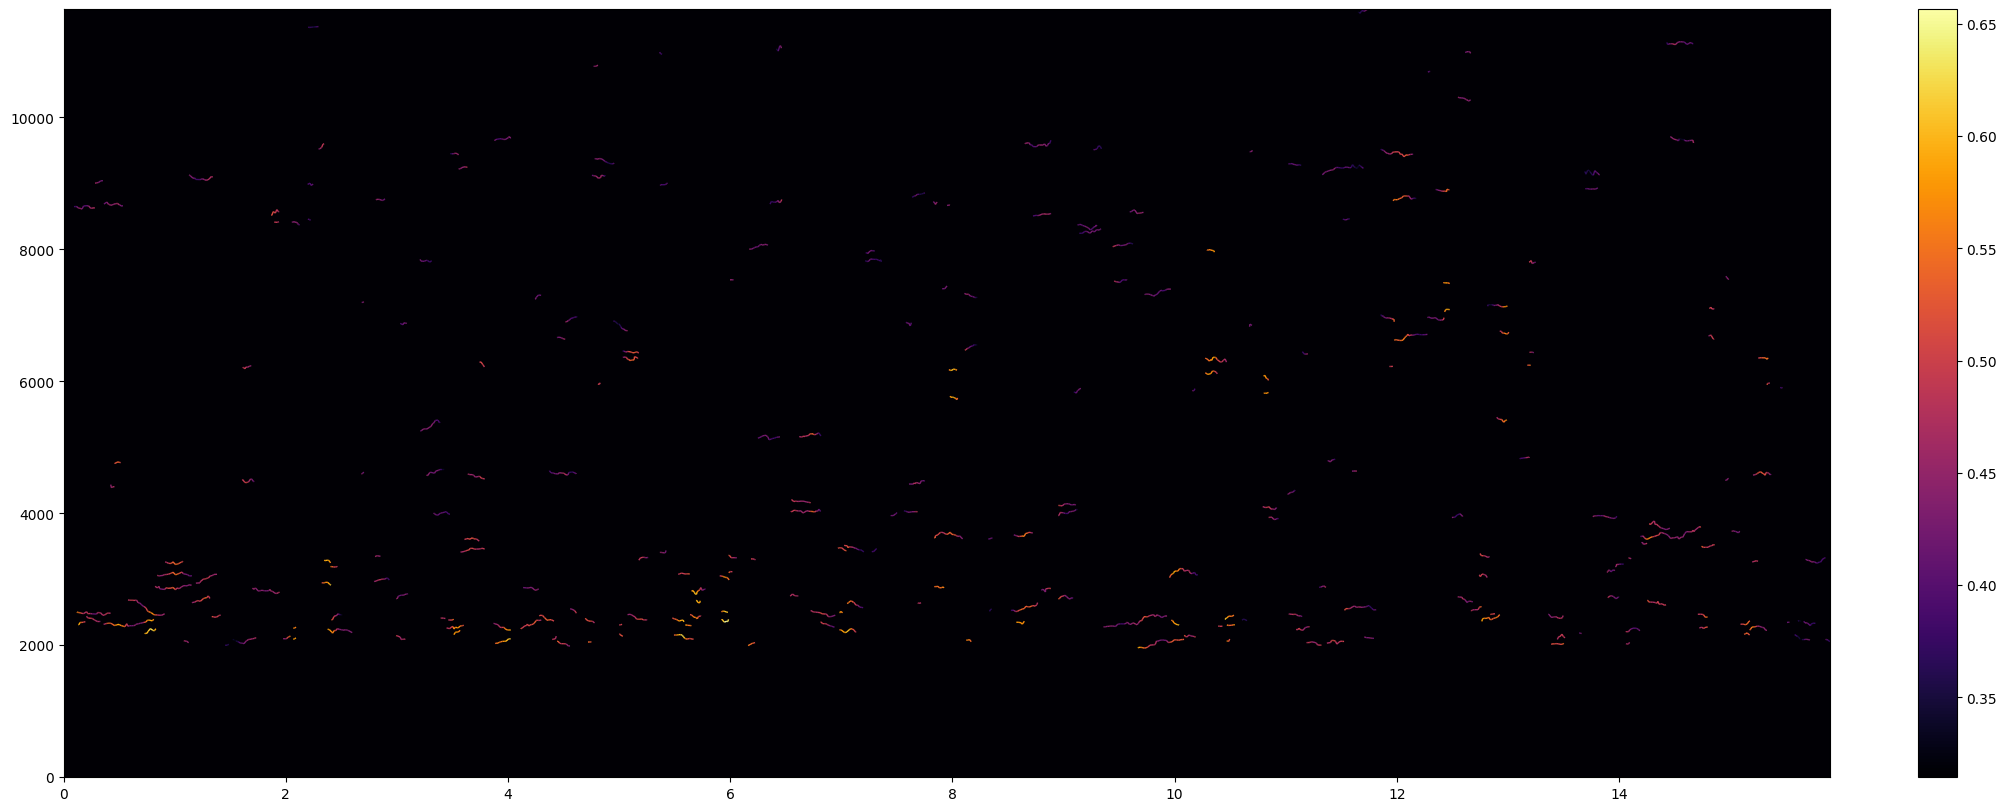

In [15]:
print(len(noisesp), sum(1 for p in noisesp if p.meanfreq() > 5000))
noisesp.plot(exp=0.1)
noisesp.synthesize()

Num partials: 1005


using libsndfile-1.2.2
sr = 48000.0, kr = 750.000, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
audio buffered in 256 sample-frame blocks
reading 2048-byte blks of shorts from adc:Built-in Audio Analog Stereo: (RAW)
writing 512 sample blks of 64-bit floats to dac:Built-in Audio Analog Stereo:
SECTION 1:


Button(description='Stop', style=ButtonStyle())

Output()

Synth(‖ .playPartials=401.0002 start=.147 dur=-1 ifn=101 iskip=0 inumrows=2155 inumcols=55 kspeed=1 kloop=0 kminfreq=0 kmaxfreq=0 iflags=6 istart=0 istop=0 kfreqscale=1 ichan=1 kbwscale=1 kgain=1 iposition=0 kfreqoffset=0 kminbw=0 kmaxbw=1 kminamp=0)

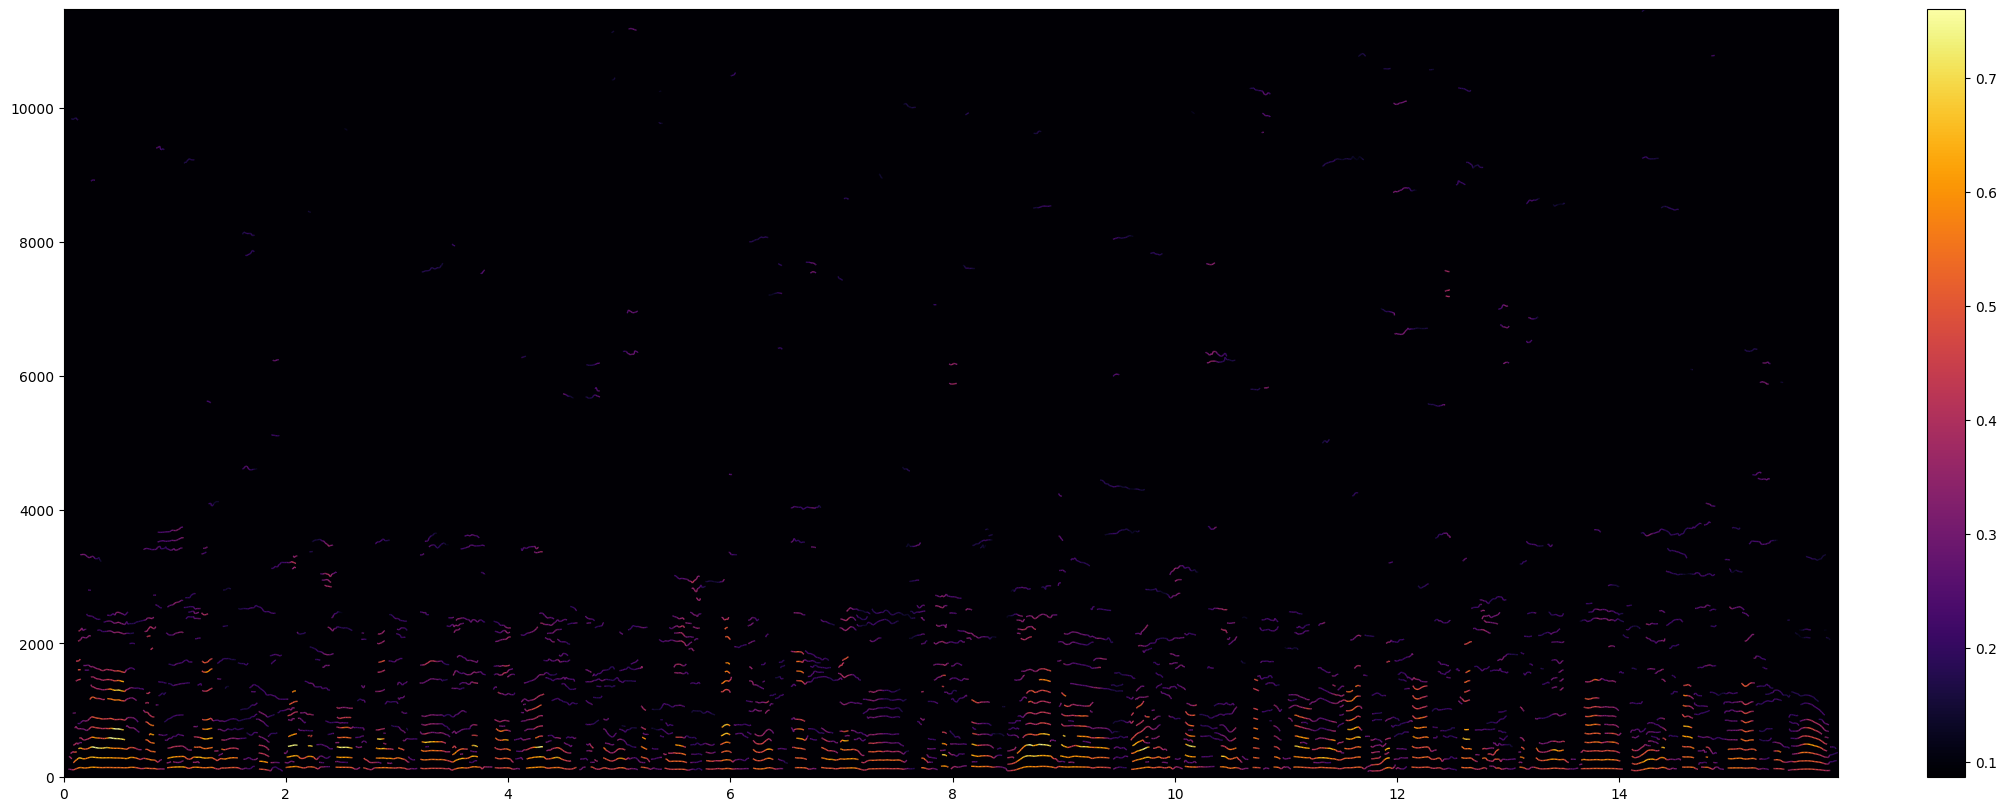

In [9]:
sp3 = Spectrum(voicedspectrum.partials + noisesp.partials)
print(f"Num partials: {len(sp3.partials)}")
sp3.plot(exp=0.2)
sp3.play()

In [10]:
out = sp2.splitInTracks(8, noisetracks=3, relerror=0.1, numbands=3, distribution=None, maxrange=12*4, audibilityCurveWeight=1., mingap=0.01, noisefreq=3500)
out.tracks

[Track(partials=54, range=2A#-6G#, start=0.043, end=15.956),
 Track(partials=78, range=2A#-6A#, start=0.142, end=15.971),
 Track(partials=61, range=2A#-6A, start=0.087, end=15.871),
 Track(partials=91, range=3C-6B, start=0.134, end=15.969),
 Track(partials=95, range=3D-7D, start=0.082, end=15.871),
 Track(partials=91, range=3A-7G#, start=0.129, end=15.937),
 Track(partials=99, range=3A-7A, start=0.048, end=15.951),
 Track(partials=87, range=4F#-8F#, start=0.062, end=15.336)]

In [11]:
partials = sum((track.partials for track in out.tracks), start=[])
partials.extend(sum((track.partials for track in out.noisetracks), start=[]))
sp2sum = Spectrum(partials)
print(len(sp2sum), len([p for p in sp2sum if p.meanfreq() > 2500]), f"{out.distribution=}")
sp2sum


904 286 out.distribution=3.53781085029577


Spectrum(numpartials=904, start=0.043, end=15.971, density=690.8)

using libsndfile-1.2.2
sr = 48000.0, kr = 750.000, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
audio buffered in 256 sample-frame blocks
reading 2048-byte blks of shorts from adc:Built-in Audio Analog Stereo: (RAW)
writing 512 sample blks of 64-bit floats to dac:Built-in Audio Analog Stereo:
SECTION 1:


Button(description='Stop', style=ButtonStyle())

Output()

Synth(‖ .playPartials=401.0002 start=.147 dur=-1 ifn=101 iskip=0 inumrows=2185 inumcols=49 kspeed=1 kloop=0 kminfreq=0 kmaxfreq=0 iflags=6 istart=0 istop=0 kfreqscale=1 ichan=2 kbwscale=1 kgain=1 iposition=0 kfreqoffset=0 kminbw=0 kmaxbw=1 kminamp=0)

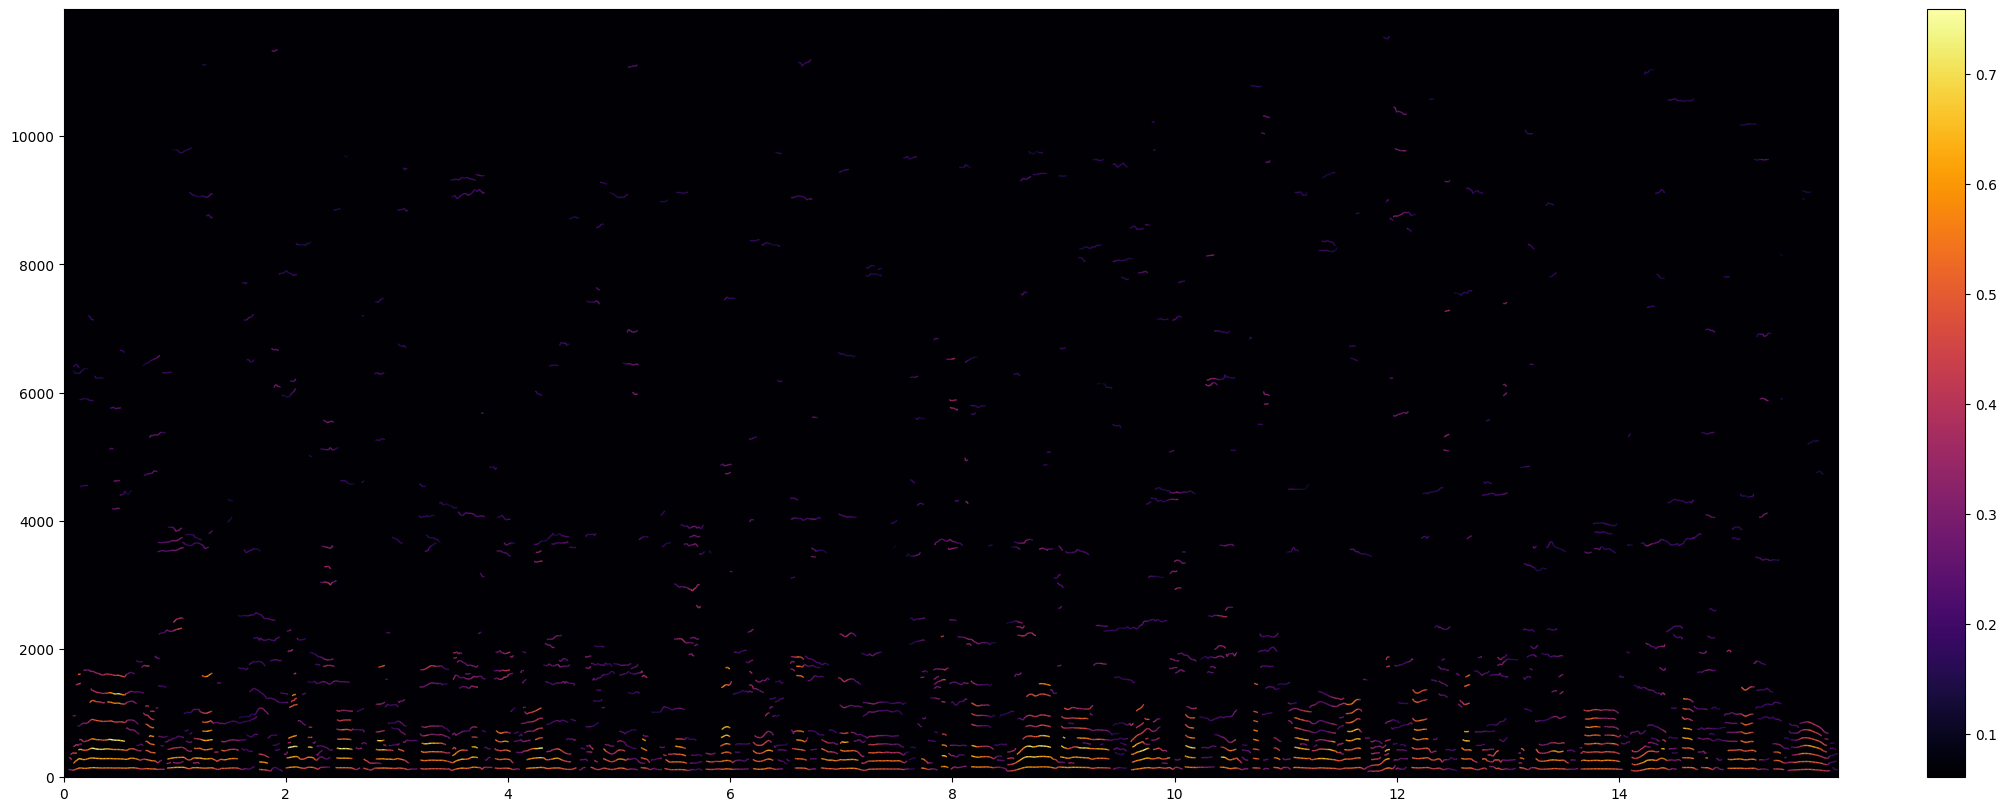

In [12]:
sp2sum.plot(exp=0.2)
sp2sum.play(chan=2)

<Axes: >

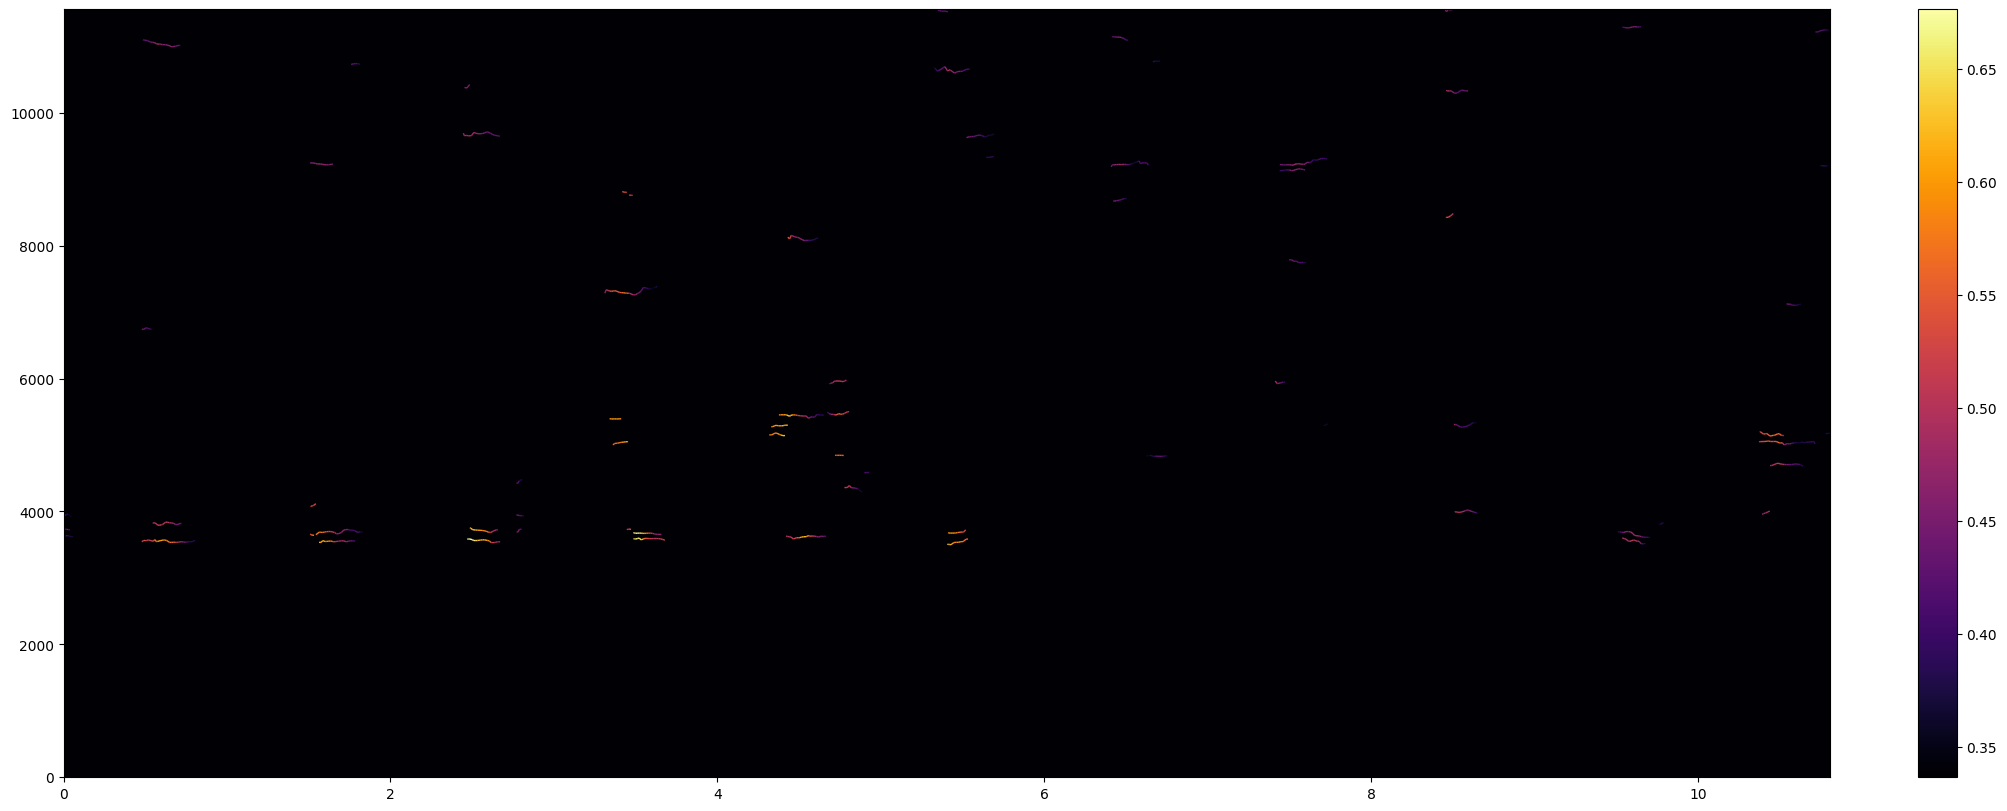

In [21]:
residualsp = Spectrum(sum((tr.partials for tr in residualtracks), start=[]))
residualsp.plot(exp=0.1)

In [22]:
residualsp.play()

Button(description='Stop', style=ButtonStyle())

Output()

Synth(‖ .playPartials=401.0008 start=133.817 dur=-1 ifn=104 iskip=0 inumrows=1405 inumcols=19 kspeed=1 kloop=0 kminfreq=0 kmaxfreq=0 iflags=6 istart=0 istop=0 kfreqscale=1 ichan=1 kbwscale=1 kgain=1 iposition=0 kfreqoffset=0 kminbw=0 kmaxbw=1 kminamp=0)

In [23]:
[p for p in sp2sum if p.meanfreq() > 1000]

[Partial(start=0.0076, end=0.0482, numbreakpoints=5, meanfreq=3949.1, meanamp=-82.9dB,
 Partial(start=0.0108, end=0.0389, numbreakpoints=5, meanfreq=3728.4, meanamp=-72.2dB,
 Partial(start=0.0129, end=0.0584, numbreakpoints=4, meanfreq=3630.0, meanamp=-82.4dB,
 Partial(start=0.4711, end=0.6760, numbreakpoints=18, meanfreq=1550.3, meanamp=-48.4dB,
 Partial(start=0.4785, end=0.8045, numbreakpoints=28, meanfreq=3555.1, meanamp=-53.0dB,
 Partial(start=0.4789, end=0.5382, numbreakpoints=7, meanfreq=6747.7, meanamp=-73.0dB,
 Partial(start=0.4794, end=0.5421, numbreakpoints=5, meanfreq=1295.2, meanamp=-70.3dB,
 Partial(start=0.4853, end=0.7137, numbreakpoints=21, meanfreq=11031.0, meanamp=-68.4dB,
 Partial(start=0.5145, end=0.8442, numbreakpoints=28, meanfreq=1620.4, meanamp=-44.6dB,
 Partial(start=0.5451, end=0.7207, numbreakpoints=16, meanfreq=3816.1, meanamp=-61.6dB,
 Partial(start=0.7299, end=0.7530, numbreakpoints=3, meanfreq=1543.0, meanamp=-64.6dB,
 Partial(start=1.5085, end=1.6480, nu